# Plot all raw asymmetry and spectra?
# take out run 109 and recreate La asym plot

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from numba import njit
# from scipy import odr
# from scipy.special import voigt_profile
from scipy.optimize import curve_fit
# from scipy import stats as st
import time

# os.chdir('F:/LANL/processed_data/')
# processedfolder = 'F:/LANL/processed_data/'

os.chdir('F:/LANL/')
# os.chdir('/mnt/c/Users/gabeo/Desktop/analysis_temp/')
root = os.getcwd()

processedfolder = '/processed_data/'

search_arr = sorted(os.listdir(root + processedfolder))
print(search_arr)
# print(search_arr[0])
# folders_start = 'runs'+'12364-12684'
# folders_start = 'runs'+'11727-12033'
# # folders_start = 'runs'+'12034-12363'
# # folders_end = 'runs'+'11727-12033'

# folders_end = 'runs'+'12364-12684'
# folders_end = 'runs'+'12034-12363'
folders_start = 'runs'+'11727-12033'
folders_end = 'runs'+'12364-12684'

print(folders_start)
start_i = search_arr.index(folders_start)
end_i = search_arr.index(folders_end)
print(start_i, end_i)
print(len(search_arr[start_i:end_i+1]))
asymDendname = '/asym_D_05.05.25/'
asymUendname = '/asym_U_05.05.25/'

firstfile = sorted(os.listdir(root+processedfolder+folders_start+asymDendname))[0]
folderslist = []
if folders_start == folders_end:
    currfolder = search_arr[start_i]+'/'
    folderslist.append(currfolder)
else:
    for f in range(start_i, end_i+1):
#         print(f)
#         print(search_arr[f])
        currfolder = root+processedfolder+search_arr[f]
        currfolder = search_arr[f]+'/'
#         print(currfolder)
        folderslist.append(currfolder)
#     runslist_D[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D'))
#     runslist_U[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_U'))

numfolders = len(folderslist)
print(folderslist)
print(numfolders)

## change below to multiple folders?
runslist_D = []  ## array of runfolders, runs
runslist_U = []
for i in range(len(folderslist)):
    runslist_D.append(sorted(os.listdir(root+processedfolder+folderslist[i]+asymDendname)))
    runslist_U.append(sorted(os.listdir(root+processedfolder+folderslist[i]+asymUendname)))
# runslist_D = sorted(os.listdir(root+processedfolder+folders_start+'/ONOFF_D')) ## has to be changed to an array
# runslist_U = sorted(os.listdir(root+processedfolder+folders_start+'/ONOFF_U'))
# runslist_D =np.asarray(runslist_D)
# runslist_U =np.asarray(runslist_U)
print(len(runslist_D))
print(len(runslist_D[0]))
# print(len(runslist_D[1]))
## now flatten list so that all runs are in one array ## not sure I will use this
flatrunslist_D = [run for folder in runslist_D for run in folder]
flatrunslist_D = np.asarray(flatrunslist_D)
flatrunslist_U = [run for folder in runslist_U for run in folder]
flatrunslist_U = np.asarray(flatrunslist_U)
print(len(flatrunslist_D))

numruns_tot_D = len(flatrunslist_D) ## U and D should be the same? ## should change to num pulses maybe
numruns_tot_U = len(flatrunslist_U) ## 
if numruns_tot_D != numruns_tot_U:
    emessage = ('# upstream files and downstream files are not the same!')
    # logger.error(run_num + emessage)
    raise Exception(emessage)
print(numruns_tot_D)
print(numruns_tot_U)

['0_vparams_La.h5', 'La_sample', '_temp_xs.npy', 'runs07862-08069', 'runs09919-10159', 'runs11121-11138', 'runs11139-11412', 'runs11413-11726', 'runs11727-12033', 'runs12034-12363', 'runs12364-12684', 'runs12686-13279', 'runs13280-13563', 'runs13564-13604', 'runs13605-13735', 'runs13736-13851', 'runs13852-14191', 'runs14192-14499', 'runs14500-15106', 'runs15114-15568', 'runs15569-16110', 'runs16135-16392', 'runs16453-16763', 'runs88888-99999', 'xs_cut.npy', 'xs_uncut.npy']
runs11727-12033
8 10
3
['runs11727-12033/', 'runs12034-12363/', 'runs12364-12684/']
3
3
306
954
954
954


In [2]:
## allows h5 loads to be easier...
foldersflat = []
for i in range(0,len(folderslist)):
    folder = folderslist[i]
    numrunsfolder = len(runslist_D[i])
    fpaths = [folder]*numrunsfolder
    foldersflat.append(fpaths)

foldersflat = [path for folder in foldersflat for path in folder]
# print(foldersflat[0])
print(len(foldersflat))
# print(len(foldersflat[0]))
# print(len(foldersflat[1]))
# print(len(foldersflat))
# print(foldersflat)

954


In [3]:
# print(len(runslist_D))
# print(len(runslist_D[0]))
# print(len(runslist_D[1]))
# ## now flatten list so that all runs are in one array ## not sure I will use this
# flatrunslist_D = [run for folder in runslist_D for run in folder]
# flatrunslist_D = np.asarray(flatrunslist_D)
# flatrunslist_U = [run for folder in runslist_U for run in folder]
# flatrunslist_U = np.asarray(flatrunslist_U)
# print(len(flatrunslist_D))

# numruns_tot_D = len(flatrunslist_D) ## U and D should be the same? ## should change to num pulses maybe
# numruns_tot_U = len(flatrunslist_U) ## 
# print(numruns_tot_D)
# print(numruns_tot_U)

In [4]:
## load in the x array. Also helps in determining sizes
## NO 6LI FOR THESE HDF5 FILES

channels_all = []
folderpath = root+processedfolder+folderslist[0]
with h5py.File(folderpath+asymDendname+runslist_D[0][0], 'r') as f: ## new arr_sizer
    channels_D = list(f.keys())
    channels_all.append(channels_D[:-1])
    numchannels = len(channels_D)-1
    dataset = f[channels_D[-1]]   ## this is the xs dataset
#     xs = np.array(dataset)*1e-6 ## now in ms
#     numpoints = len(xs)
    f.close()
    
with h5py.File(folderpath+asymUendname+runslist_U[0][0], 'r') as f: ## new arr_sizer
    channels_U = list(f.keys())
    channels_all=np.append(channels_all, channels_U[:-1])
#     channels_all.append(channels[:-1])
    numchannels = len(channels_U)-1
    dataset = f[channels_U[-1]]   ## this is the xs dataset
    xs = np.array(dataset)*1e-6 ## now in ms
    numpoints = len(xs)
    f.close()
# print(channels_all)
# channels_all = np.asarray(channels_all, dtype=object)
# print(channels_all)
# channels_all = channels_all.flatten()
print(numruns_tot_D,numchannels,numpoints)
# print(data.shape)
# print(data[seq][0][0])
# print(channels_all[:])
print(channels_all[-1])
print(len(xs))

print(channels_D)
print(channels_U)
print(channels_all)

# print(channels_all.flatten())
# print(data)

954 12 8992
ch_23
8992
['ch_00', 'ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07', 'ch_08', 'ch_09', 'ch_10', 'ch_11', 'xs ']
['ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23', 'xs ']
['ch_00' 'ch_01' 'ch_02' 'ch_03' 'ch_04' 'ch_05' 'ch_06' 'ch_07' 'ch_08'
 'ch_09' 'ch_10' 'ch_11' 'ch_12' 'ch_13' 'ch_14' 'ch_15' 'ch_16' 'ch_17'
 'ch_18' 'ch_19' 'ch_20' 'ch_21' 'ch_22' 'ch_23']


In [5]:
# ## loads on/off added pulses. not needed for asym based on multiplicative factor ##
numsequences = []
run_ampasym_D = []
run_ampasym_U = []
run_rawasym_D = []
run_rawasym_U = []
# totnumchan = len(run_asyms_D[0])+len(run_asyms_U_noLi[0])

folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders

for i in range(0,len(runslist_D)):
    runname = folderpath+asymDendname+runslist_D[0][i]  ##[0] indicates the first folder
    print(runname)
    with h5py.File(runname, 'r') as f:
        print("Keys: %s" % f.keys())
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_seq = f.attrs.get('sequences')
        numsequences.append(num_seq)
        runamp = []
        runraw = []
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        for i in range(0,numchannels):
            chsubgrp = f[channels[i]]  ##change this to match channels[i]
#             print(list(chsubgrp.attrs))
            asym_amp_data = np.array(chsubgrp.attrs.get('asym_amp'))
            asym_raw_chdataset = np.array(chsubgrp['asym_raw'])
#             print(asym_raw_chdataset)
            runamp.append(asym_amp_data)
            runraw.append(asym_raw_chdataset)
        run_ampasym_D.append(runamp)
        run_rawasym_D.append(runraw)
        f.close()
#         folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders


F:\LANL/processed_data/runs11727-12033//asym_D_05.05.25/11727_D.h5
Keys: <KeysViewHDF5 ['ch_00', 'ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07', 'ch_08', 'ch_09', 'ch_10', 'ch_11', 'xs ']>
F:\LANL/processed_data/runs11727-12033//asym_D_05.05.25/11728_D.h5
Keys: <KeysViewHDF5 ['ch_00', 'ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07', 'ch_08', 'ch_09', 'ch_10', 'ch_11', 'xs ']>
F:\LANL/processed_data/runs11727-12033//asym_D_05.05.25/11729_D.h5
Keys: <KeysViewHDF5 ['ch_00', 'ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07', 'ch_08', 'ch_09', 'ch_10', 'ch_11', 'xs ']>


In [6]:
print(len(run_rawasym_D)) ## no. folders
print(len(run_rawasym_D[0])) ## no. channels
print(len(run_rawasym_D[0][0])) ## no. points
print()
print(len(run_ampasym_D)) ## no. folders
print(len(run_ampasym_D[0])) ## no. channels
print(len(run_ampasym_D[0][0])) ## parameter, error


3
12
8992

3
12
2


In [7]:
print(flatrunslist_D[109:110])

['11836_D.h5']


In [8]:

def loadrun_asym(run, processedpath): ## not sure if this is the fastest way, or passing a list of runs...
    runname = processedpath+run
    runamp = []
    runintegral = []
#     print(runname)
#     numsequences = []
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_seq = f.attrs.get('sequences')
        puck = f.attrs.get('puck_state')
#         print(puck)
        if puck != 0:
            print(run, puck)
        runraw = np.zeros((numchannels,numpoints),dtype = np.float64) ## numpoints gotten from few cells up
        for i in range(0,numchannels):
            chsubgrp = f[channels[i]]
            chraw = np.array(chsubgrp['asym_raw'])  ##change this to match channels[i]
            runraw[i] = runraw[i]+chraw
            runampch = chsubgrp.attrs.get('asym_amp')
            runintegralch = chsubgrp.attrs.get('asym_integral')
            runamp.append(runampch[0])  #[0] is the asym from amp as opposed to the error [1]
            runintegral.append(runintegralch)  # currently no error for integral, just scaler
        f.close()
#     print((runamp))
#     print(num_seq)
    return runraw, runamp, runintegral, num_seq 

start=time.time()
# all_D = [] ## in this case cannot be np array because it is not same size arrays ## will be run, channel, numpoints
all_raw_D = np.zeros((numruns_tot_D, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
all_raw_U = np.zeros((numruns_tot_U, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
all_amp_D = np.zeros((numruns_tot_D, numchannels),dtype = np.float64) ## run, channel 
all_amp_U = np.zeros((numruns_tot_U, numchannels),dtype = np.float64) ## run, channel 
all_integral_D = np.zeros((numruns_tot_D, numchannels),dtype = np.float64) ## run, channel 
all_integral_U = np.zeros((numruns_tot_U, numchannels),dtype = np.float64) ## run, channel 
all_sequences = np.zeros((numruns_tot_D),dtype = np.float64) ## num runs
# print(len(all_amp_D))

for r in range(0, len(flatrunslist_D)):
    fpath = root+processedfolder+foldersflat[r]
    full = len(flatrunslist_D)
#     print(fpath)
#     print(len(all_amp_D[r]))
    if r == round(full/5) or r == round(2*full/5) or r == round(3*full/5) or r == round(4*full/5) or r == full-1:
        print('1/5 runs complete ', r)
#     print(flatrunslist_D[r])
    all_raw_D[r], all_amp_D[r], all_integral_D[r], all_sequences[r] = loadrun_asym(flatrunslist_D[r], fpath+asymDendname)
    all_raw_U[r], all_amp_U[r], all_integral_U[r], all_sequences[r] = loadrun_asym(flatrunslist_U[r], fpath+asymUendname)

print(all_raw_D.shape)
all_raw_D = np.asarray(all_raw_D.transpose(1,0,2))  ## re-shape into ch, run, points
all_raw_U = np.asarray(all_raw_U.transpose(1,0,2))
print(all_raw_D.shape)

print(all_amp_D.shape)
all_amp_D = np.asarray(all_amp_D.transpose(1,0))
all_amp_U = np.asarray(all_amp_U.transpose(1,0))
print(all_amp_D.shape)

print(all_amp_D.shape)
all_integral_D = np.asarray(all_integral_D.transpose(1,0))
all_integral_U = np.asarray(all_integral_U.transpose(1,0))
print(all_amp_D.shape)

all_raw = np.vstack((all_raw_D,all_raw_U))
# del all_raw_D ## might help with memory issues
# del all_raw_U
all_amp = np.vstack((all_amp_D,all_amp_U))
all_integral = np.vstack((all_integral_D,all_integral_U))

all_amp_norm = all_amp/(all_sequences) # need weighted avg?
all_integral_norm = all_integral/(all_sequences) # need weighted avg?

end=time.time()
print('loaded files time: ', end-start)

1/5 runs complete  191
1/5 runs complete  382
1/5 runs complete  572
1/5 runs complete  763
1/5 runs complete  953
(954, 12, 8992)
(12, 954, 8992)
(954, 12)
(12, 954)
(12, 954)
(12, 954)
loaded files time:  48.54155993461609


In [9]:
import sys
memory_usage = sys.getsizeof(all_raw_D)
print(f"Memory usage of the list: {memory_usage} bytes")
memory_usage = sys.getsizeof(all_amp_D)
print(f"Memory usage of the list: {memory_usage} bytes")
memory_usage = sys.getsizeof(all_integral_D)
print(f"Memory usage of the list: {memory_usage} bytes")

# del all_raw_D ## might help with memory issues
# del all_raw_U

memory_usage = sys.getsizeof(run_rawasym_D)
print(f"Memory usage of the list: {memory_usage} bytes")
memory_usage = sys.getsizeof(run_ampasym_D)
print(f"Memory usage of the list: {memory_usage} bytes")
memory_usage = sys.getsizeof(flatrunslist_D)
print(f"Memory usage of the list: {memory_usage} bytes")

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


Memory usage of the list: 144 bytes
Memory usage of the list: 128 bytes
Memory usage of the list: 128 bytes
Memory usage of the list: 88 bytes
Memory usage of the list: 88 bytes
Memory usage of the list: 38272 bytes
                       all_raw:  1.5 GiB
                       all_amp: 179.0 KiB
                  all_integral: 179.0 KiB
                  all_amp_norm: 179.0 KiB
             all_integral_norm: 179.0 KiB
                            xs: 70.4 KiB
            asym_raw_chdataset: 70.4 KiB
                flatrunslist_D: 37.4 KiB
                flatrunslist_U: 37.4 KiB
                   foldersflat:  7.6 KiB


In [10]:
del all_raw_D ## might help with memory issues
del all_raw_U
del run_rawasym_D
del run_rawasym_U
del run_ampasym_D
del run_ampasym_U
del flatrunslist_D
del flatrunslist_U
del asym_raw_chdataset

24 24
8992
8992
[-0.00638228 -0.00643593 -0.00604714 -0.00506055 -0.00602146 -0.00508488
 -0.00634729 -0.00595921 -0.00471928 -0.00626886 -0.00571832 -0.006874
 -0.00576297 -0.0060494  -0.00663443 -0.00687203 -0.00643414 -0.00678733
 -0.00683418 -0.00645499 -0.00703146 -0.00639737 -0.00616873 -0.00604589]


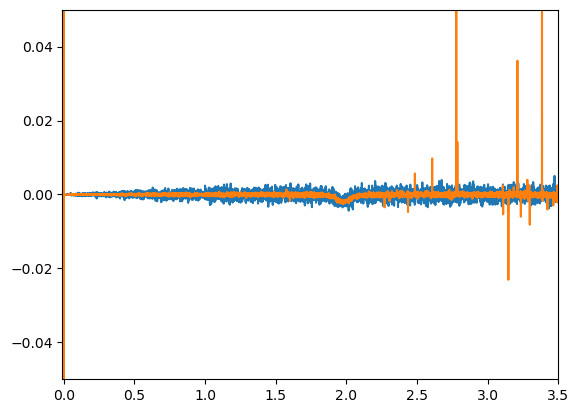

In [11]:
## testing things to see the large values...
## downstream looks okay for 12364 runs
## something happened with 11727:12033 runs
## problem at run 11727+109 starting 

sum_ch_raw = []
sum_ch_amp = []
p1 = 109
p2 = -1
for ch in range(0, len(all_raw)):
    chraw = np.sum(all_raw[ch,p1:p2], axis = 0)
    champ = np.sum(all_amp[ch,p1:p2], axis = 0)
    sum_ch_raw.append(chraw)
    sum_ch_amp.append(champ)

    
sum_ch_amp = sum_ch_amp/np.sum(all_sequences) ## normalize sum of amplitudes!
    
print(len(sum_ch_raw), len(sum_ch_amp))
print(len(sum_ch_raw[0]))
    
allNaI_raw = np.sum(sum_ch_raw[0:24], axis = 0)
%matplotlib inline
print(len(allNaI_raw))
plt.plot(xs, sum_ch_raw[1]/np.sum(all_sequences))
plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.05, 0.05)
plt.xlim(-0.01, 3.5)
# print(len(all_raw_D[0]))
print(sum_ch_amp)

In [12]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       all_raw:  1.5 GiB
                       all_amp: 179.0 KiB
                  all_integral: 179.0 KiB
                  all_amp_norm: 179.0 KiB
             all_integral_norm: 179.0 KiB
                            xs: 70.4 KiB
                         chraw: 70.4 KiB
                    allNaI_raw: 70.4 KiB
                   foldersflat:  7.6 KiB
                 all_sequences:  7.6 KiB


In [13]:

def loadrun_pulseadd(run, processedpath): ## not sure if this is the fastest way, or passing a list of runs...
    runname = processedpath+run
#     print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        arrsizer = f[channels[-1]] ## gets the xs array
        arrsizer = np.asarray(arrsizer)
        numpoints = len(arrsizer)
#             num_seq = f.attrs.get('sequences')
#             numsequences.append(num_seq)
        rundat = np.zeros((numchannels,numpoints),dtype = np.float64)
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        for i in range(0,numchannels):
            dataset = f[channels[i]+'/added_pulses/'+channels[i]][:]  ##change this to match channels[i]
            chdata = np.array(dataset)
#                     print(chdata)
#                     print(np.size(chdata))
#                     print(len(chdata[0]))
#                     print(rundat)
            rundat[i] = rundat[i]+chdata
        f.close()
    return rundat

start=time.time()
# all_D = [] ## in this case cannot be np array because it is not same size arrays ## will be run, channel, numpoints
# all_D = np.zeros((numruns_tot_D, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
# all_U = np.zeros((numruns_tot_U, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
all_D = []
all_U = []

for f in range(0,len(folderslist)):
    fpath = root+processedfolder+folderslist[f]
    for r in range(0, len(runslist_D[f])):
#         print(runslist_D[f][r])
#         all_D.append(loadrun_pulseadd(runslist_D[f][r], fpath+'/pulseadd_D/'))
#         print(r)
#         all_D[r] = loadrun_pulseadd(runslist_D[f][r], fpath+'/pulseadd_D/')
#         all_U[r] = loadrun_pulseadd(runslist_U[f][r], fpath+'/pulseadd_U/')
        all_D.append(loadrun_pulseadd(runslist_D[f][r][:5]+'_pulseadd_D.h5', fpath+'/pulseadd_D/'))  ## added pulseadd str to this
        all_U.append(loadrun_pulseadd(runslist_U[f][r][:5]+'_pulseadd_U.h5', fpath+'/pulseadd_U/'))
#         print(all_D[r])
    print(fpath+' done')

all_D = np.asarray(all_D)
all_U = np.asarray(all_U)
    
print(all_D.shape)
all_D = np.asarray(all_D.transpose(1,0,2))  ## re-shape into ch, run, points
all_U = np.asarray(all_U.transpose(1,0,2))
print(all_D.shape)
    
end=time.time()
print('loaded pulseadd files time: ', end-start)

F:\LANL/processed_data/runs11727-12033/ done
F:\LANL/processed_data/runs12034-12363/ done
F:\LANL/processed_data/runs12364-12684/ done
(954, 13, 8992)
(13, 954, 8992)
loaded pulseadd files time:  31.604373931884766


In [14]:
    memory_usage = sys.getsizeof(all_D)
    print(f"Memory usage of the list: {memory_usage} bytes")

    def sizeof_fmt(num, suffix='B'):
        ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
        for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
            if abs(num) < 1024.0:
                return "%3.1f %s%s" % (num, unit, suffix)
            num /= 1024.0
        return "%.1f %s%s" % (num, 'Yi', suffix)

    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                              locals().items())), key= lambda x: -x[1])[:10]:
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

Memory usage of the list: 144 bytes
                       all_raw:  1.5 GiB
                       all_amp: 179.0 KiB
                  all_integral: 179.0 KiB
                  all_amp_norm: 179.0 KiB
             all_integral_norm: 179.0 KiB
                            xs: 70.4 KiB
                         chraw: 70.4 KiB
                    allNaI_raw: 70.4 KiB
                   foldersflat:  7.6 KiB
                 all_sequences:  7.6 KiB


In [15]:
print(all_amp[1][630:640])
print(all_amp_norm[1][630:640])
print(all_amp[1][630:640]/13)


[-0.27143494 -0.01734818 -0.07542289 -0.06809608 -0.20393952 -0.11542692
 -0.16874052  0.19981005 -0.02376801 -0.00760241]
[-0.02087961 -0.00133448 -0.00580176 -0.00523816 -0.01568766 -0.01049336
 -0.01298004  0.01537    -0.00182831 -0.0005848 ]
[-0.02087961 -0.00133448 -0.00580176 -0.00523816 -0.01568766 -0.00887899
 -0.01298004  0.01537    -0.00182831 -0.0005848 ]


In [16]:
# print(round(len(flatrunslist_D)/5))
print(len(all_sequences))
print(len(all_amp[0]))
# print(len(np.sum(all_amp)))
print((np.where(all_sequences<=12)))
print(all_sequences[(np.where(all_sequences<=12))])
print(np.sum(all_sequences))
print(13*954)
# print(all_amp)


954
954
(array([635, 953]),)
[11.  3.]
12390.0
12402


In [17]:
# ## previously used for checking vstack

# %matplotlib inline
# # all_raw = np.vstack((all_raw_D,all_raw_U))
# # all_amp = np.vstack((all_amp_D,all_amp_U))
# # all_amp_norm = all_amp/all_sequences

# # plt.plot(xs, all_raw_D[-1][20])
# # plt.plot(xs, all_raw[11][20])
# plt.plot(xs, all_raw_U[-1][20])
# plt.plot(xs, all_raw[-1][20])
# plt.ylim(-100, 100)
# plt.xlim(-0.01, 3)
# # print(len(all_raw_D[0]))
# for i in range(0,12):
#     if all_raw_U[i][20][50] == all_raw[i+12][20][50]:
#         print('yay')
#     if all_raw_D[i][20][50] == all_raw[i][20][50]:
#         print('yay 2')
#     else: 
#         print('boo')
# # testrans = np.asarray(all_raw_D.transpose(1,0,2))
# # testranssum = np.sum(testrans[ch,:], axis = 0)
# # plt.plot(xs, testranssum)

In [18]:
## testing delete

# import numpy as np

# all_raw_D = np.zeros((950, 24,8992),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
# arr = all_raw_D
# print(arr.shape)

# arr = np.delete(arr, 109, 0)
# print(arr.shape)
# all_raw_D = np.zeros((24, 950,8992),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
# arr = all_raw_D
# print(arr.shape)

# arr = np.delete(arr, 109, 1)
# print(arr.shape)

In [26]:
print(len(all_raw[0]))

954


8992


(-0.01, 4.0)

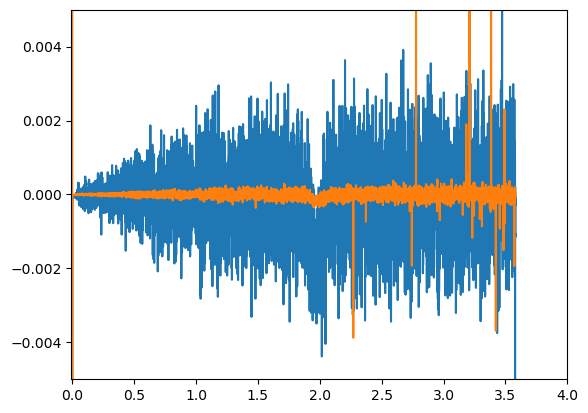

In [31]:
allNaI_raw = np.sum(sum_ch_raw[3:5], axis = 0)
%matplotlib inline
print(len(allNaI_raw))
plt.plot(xs, sum_ch_raw[1]/np.sum(all_sequences))
plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.005, 0.005)
plt.xlim(-0.01, 4.0)

In [21]:
# print(np.array(all_raw).shape)
# # print(np.where(all_raw[0][:][:]<= 5))
# p1 = 0
# p2 = 150
# for i in range(p1,p2):
#     plt.plot(all_raw[3][i])

# plt.xlim(2200,9000)
# plt.ylim(-10, 10)
# # plt.show()

In [28]:
print(len(all_integral_norm))

24


-0.006931
-0.006183004651048739


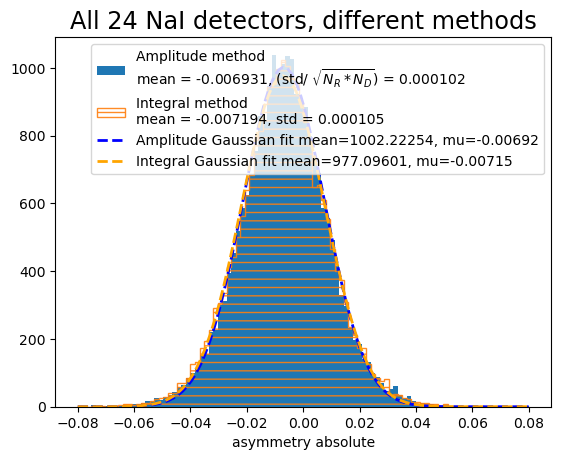

-0.007194


In [29]:
## all 24, amplitude / integral

%matplotlib inline
r = [-0.08,0.08]
b = 100

all_NaI_amp = all_amp_norm.flatten()
# all_NaI_amp = np.sum(all_amp_norm, axis = 0)
# print(len(testsum))
plt.title(rf'All 24 NaI detectors, different methods', fontsize = 'xx-large')
mean = np.round(np.mean(all_NaI_amp),6)
std = np.round(np.std(all_NaI_amp)/(np.sqrt(numruns_tot_D*24)),6)

n_amp, bins_amp, patches_amp = plt.hist(all_NaI_amp,bins=b,range=r, label = f'Amplitude method\nmean = {mean}, (std/ $\sqrt{{N_R*N_D}}$) = {std}')
print(mean)
print(np.mean(sum_ch_amp))

all_NaI_integral = all_integral_norm.flatten()
# all_NaI_integral = np.sum(all_integral_norm, axis = 0)
# print(len(testsum))
# plt.title(rf'maybe all 24 detectors using integral over FWHM', fontsize = 'xx-large')
mean2 = np.round(np.mean(all_NaI_integral),6)
std2 = np.round(np.std(all_NaI_integral)/(np.sqrt(numruns_tot_D*24)),6)

n_int, bins_int, patches_int = plt.hist(all_NaI_integral,bins=b,range=r, label = f'Integral method\nmean = {mean2}, std = {std2}', alpha =0.9, hatch='--',histtype='step')

def gauss(x,amp,mu,sigma): # deinition of function
    return amp*np.exp(-(x-mu)**2/2*sigma**2)

y_amp = n_amp
y_int = n_int
x = np.linspace(r[0],r[1], b)

popt_amp,pcov_amp=curve_fit(gauss,x,y_amp,p0=[100,0,2]) # popt= optimize parameter
plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amplitude Gaussian fit mean={np.round(popt_amp[0],5)}, mu={np.round(popt_amp[1],5)}')
popt_int,pcov_int=curve_fit(gauss,x,y_int,p0=[100,0,2]) # popt= optimize parameter
plt.plot(x,gauss(x,*popt_int),color='orange',lw=2.0,ls = '--',label=f'Integral Gaussian fit mean={np.round(popt_int[0],5)}, mu={np.round(popt_int[1],5)}')
# print('amp',popt[0]) # amp
# print('meam',popt[1])# mean mu
# print('sigma',popt[2]) # sigma


plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()
print(mean2)
# print(np.mean(sum_ch_integral))


In [86]:
## general function for reduced chi square for a given fit function. sigma is important to estimate.

def chi_square_dof(fit_func, xdata, ydata, popt, sigma=None):
    """
    Calculate chi-square and degrees of freedom for a fit.

    Parameters:
        fit_func : callable
            The model function, f(x, ...).
        xdata : array_like
            The independent variable where the data is measured.
        ydata : array_like
            The dependent data — measured values.
        popt : array_like
            Optimal values for the parameters from curve_fit.
        sigma : array_like or None
            Standard deviation errors of ydata. If None, equal weights assumed.

    Returns:
        chi2 : float
            Chi-square statistic.
        dof : int
            Degrees of freedom.
        reduced_chi2 : float
            Reduced chi-square (chi2 / dof)
    """
    yfit = fit_func(xdata, *popt)
    residuals = ydata - yfit
    if sigma is None:
        chi2 = np.sum(residuals**2)
    else:
        chi2 = np.sum((residuals / sigma)**2)
    dof = len(ydata) - len(popt)
    reduced_chi2 = chi2 / (dof)
    return residuals, chi2, dof, reduced_chi2

def gauss(x,amp,mu,sigma): # deinition of function
    return amp*np.exp(-(x-mu)**2/2*sigma**2)

-0.006931
-0.006183004651048739
chi square/dof for amp:  3.055082531016778
chi square/dof for int:  2.813000126298163


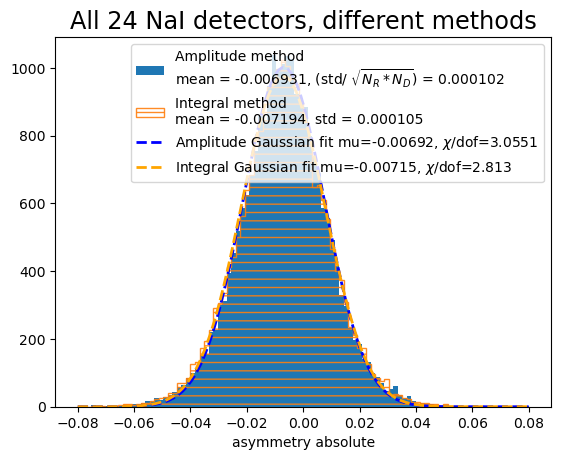

-0.007194


In [142]:
## all 24, amplitude / integral
## redo with chisquare for gaussian fit

%matplotlib inline
r = [-0.08,0.08]
b = 100

all_NaI_amp = all_amp_norm.flatten()
# all_NaI_amp = np.sum(all_amp_norm, axis = 0)
# print(len(testsum))
plt.title(rf'All 24 NaI detectors, different methods', fontsize = 'xx-large')
mean = np.round(np.mean(all_NaI_amp),6)
std = np.round(np.std(all_NaI_amp)/(np.sqrt(numruns_tot_D*24)),6)
n_amp, bins_amp, patches_amp = plt.hist(all_NaI_amp,bins=b,range=r, label = f'Amplitude method\nmean = {mean}, (std/ $\sqrt{{N_R*N_D}}$) = {std}')
print(mean)
print(np.mean(sum_ch_amp))

all_NaI_integral = all_integral_norm.flatten()
# all_NaI_integral = np.sum(all_integral_norm, axis = 0)
# print(len(testsum))
# plt.title(rf'maybe all 24 detectors using integral over FWHM', fontsize = 'xx-large')
mean2 = np.round(np.mean(all_NaI_integral),6)
std2 = np.round(np.std(all_NaI_integral)/(np.sqrt(numruns_tot_D*24)),6)

n_int, bins_int, patches_int = plt.hist(all_NaI_integral,bins=b,range=r, label = f'Integral method\nmean = {mean2}, std = {std2}', alpha =0.9, hatch='--',histtype='step')

y_amp = n_amp
y_int = n_int
x = np.linspace(r[0],r[1], b)

popt_amp,pcov_amp=curve_fit(gauss,x,y_amp,p0=[100,0,2]) # popt= optimize parameter
# s_test = np.ones(len(y_amp))*15
# s_test = np.ones(len(y_amp))*np.mean(np.abs(chi2_amp[0]))
# s_test = np.ones(len(y_amp))*np.std(all_NaI_amp)
s_test = np.sqrt(y_amp)
s_test[s_test == 0] = 1
# print(np.std(all_NaI_amp))

# print(np.sqrt(numruns_tot_D*24))
# print(s_test)
chi2_amp = chi_square_dof(gauss,x,y_amp, popt_amp, s_test)
# print(np.mean(np.abs(chi2_amp[0])))
print('chi square/dof for amp: ', chi2_amp[-1])
plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amplitude Gaussian fit mu={np.round(popt_amp[1],5)}, $\chi$/dof={np.round(chi2_amp[-1],4)}')
popt_int,pcov_int=curve_fit(gauss,x,y_int,p0=[100,0,2]) # popt= optimize parameter

s_test = np.sqrt(y_int)
s_test[s_test == 0] = 1
chi2_int = chi_square_dof(gauss,x,y_int, popt_int, s_test)
# print(np.mean(np.abs(chi2_int[0])))
print('chi square/dof for int: ', chi2_int[-1])
plt.plot(x,gauss(x,*popt_int),color='orange',lw=2.0,ls = '--',label=f'Integral Gaussian fit mu={np.round(popt_int[1],5)}, $\chi$/dof={np.round(chi2_int[-1],4)}')
# print('amp',popt[0]) # amp
# print('meam',popt[1])# mean mu
# print('sigma',popt[2]) # sigma


plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()
print(mean2)
# print(np.mean(sum_ch_integral))


In [126]:
print(np.sqrt(y_amp))

[ 0.          0.          1.          0.          0.          0.
  1.41421356  1.41421356  0.          1.          0.          1.
  0.          1.          0.          0.          0.          1.
  1.41421356  0.          1.          2.          0.          1.41421356
  2.64575131  1.41421356  2.          2.23606798  2.44948974  2.
  2.82842712  3.          3.46410162  2.44948974  3.46410162  3.74165739
  2.82842712  3.31662479  3.          4.58257569  3.87298335  4.58257569
  3.87298335  5.38516481  5.29150262  5.47722558  5.38516481  5.91607978
  5.74456265  7.21110255  6.32455532  7.74596669  6.92820323  8.06225775
  8.83176087  8.60232527  8.94427191  8.71779789 10.53565375 10.53565375
 10.         11.18033989 11.3137085  13.15294644 12.24744871 12.76714533
 14.14213562 13.92838828 15.39480432 14.76482306 15.23154621 16.94107435
 16.91153453 17.3781472  17.2626765  18.05547009 18.13835715 18.84144368
 19.57038579 19.31320792 20.83266666 20.5669638  20.32240143 20.83266666
 20.928449

11448 11448


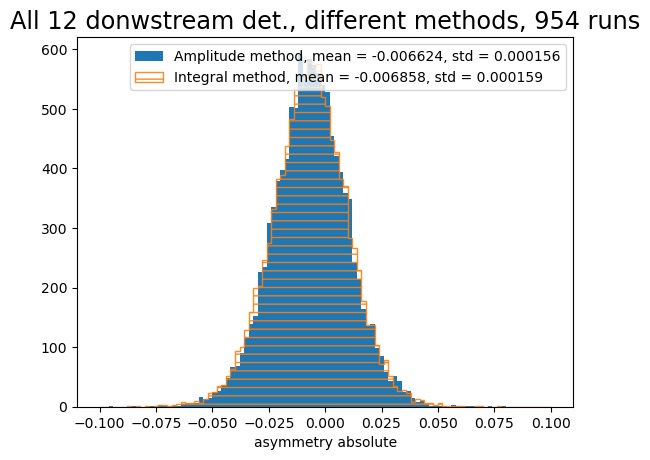

11448


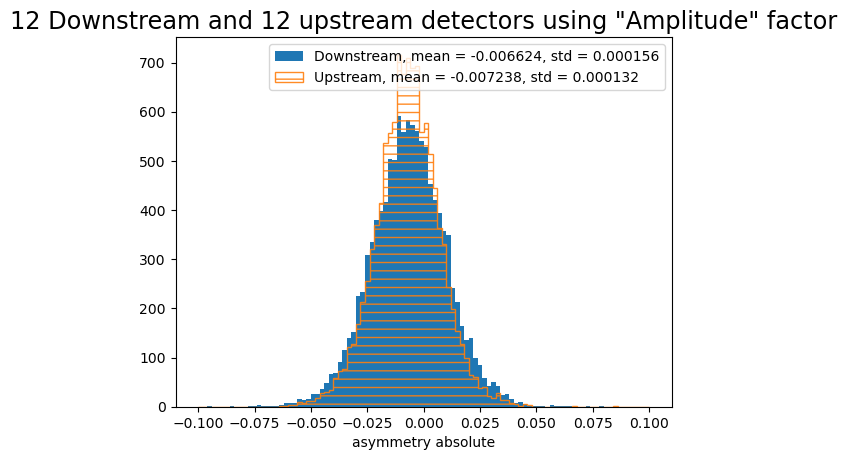

In [34]:
## upstream / downstream 

%matplotlib inline
r = [-0.1,0.1]
b = 100
all_amp_norm_D = (all_amp_D/all_sequences).flatten()
all_integral_norm_D = (all_integral_D/all_sequences).flatten()
print(len(all_amp_norm_D), len(all_integral_norm_D))
mean = np.round(np.mean(all_amp_norm_D),6)
std = np.round(np.std(all_amp_norm_D)/(np.sqrt(numruns_tot_D*12)),6)
mean2 = np.round(np.mean(all_integral_norm_D),6)
std2 = np.round(np.std(all_integral_norm_D)/(np.sqrt(numruns_tot_D*12)),6)

plt.hist(all_amp_norm_D, bins=b,range=r, label = f'Amplitude method, mean = {mean}, std = {std}')
plt.hist(all_integral_norm_D, bins=b,range=r, label = f'Integral method, mean = {mean2}, std = {std2}', alpha =0.9, hatch='--',histtype='step')
# plt.figure()
# plt.hist(all_integral_norm[ch+1], bins =bval, range = r, alpha =0.9, hatch='--',histtype='step', label = channels_all[ch+1]+f', mean = {mean2}, (plain) std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.title(f'All 12 donwstream det., different methods, {numruns_tot_D} runs', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend(fontsize = 'medium')
plt.show()

plt.figure()
all_amp_norm_U = (all_amp_U/all_sequences).flatten()
print(len(all_amp_norm_U))
mean_U = np.round(np.mean(all_amp_norm_U),6)
# std = np.round(np.std(all_amp_norm_U),6)
std_U = np.round(np.std(all_amp_norm_U)/(np.sqrt(numruns_tot_U*12)),6)

# plt.hist(all_amp_norm_U, bins = b, range=r, label = rf'mean = {mean}, std = {std}')
plt.hist(all_amp_norm_D, bins=b,range=r, label = f'Downstream, mean = {mean}, std = {std}')
plt.hist(all_amp_norm_U, bins=b,range=r, label = f'Upstream, mean = {mean_U}, std = {std_U}', alpha =0.9, hatch='--',histtype='step')

plt.title(rf'12 Downstream and 12 upstream detectors using "Amplitude" factor', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

In [32]:
print(all_amp_norm.shape)
print(all_amp_norm[6][50:60])

print(all_amp_norm[[0,3,6,9,12,15,18,21]][50:60])

corners = [0,3,6,9,12,15,18,21]
corner_amp_norm = np.asarray(all_amp_norm[corners])
print(corner_amp_norm.shape)
print(corner_amp_norm[2][50:60])


(24, 954)
[-2.30711494e-02 -5.70776156e-03  1.37995534e-02 -7.37013806e-02
 -7.20923342e-03  2.77164812e-02  3.33319613e-03 -1.43435794e-02
  1.01867750e-02  9.72336444e-05]
[]
(8, 954)
[-2.30711494e-02 -5.70776156e-03  1.37995534e-02 -7.37013806e-02
 -7.20923342e-03  2.77164812e-02  3.33319613e-03 -1.43435794e-02
  1.01867750e-02  9.72336444e-05]


24
(8, 954) (7632,)
(16, 954) (15264,)
15264


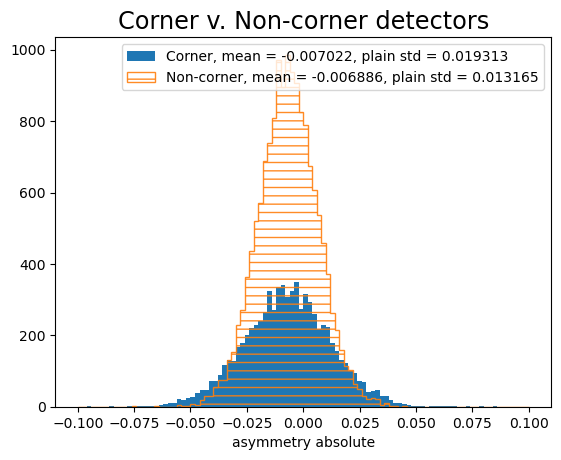

In [33]:
## corner v noncorner

print(len(all_amp_norm))
# corners = [0,3,6,9] ## downstream (?)
corners = [0,3,6,9,12,15,18,21]
corner_amp_norm = np.asarray(all_amp_norm[corners]).flatten()
print(all_amp_norm[corners].shape, (corner_amp_norm.shape))
mean = np.round(np.mean(corner_amp_norm),6)
std = np.round(np.std(corner_amp_norm),6) ## len of corner_amp_norm = numruns*8 (8 corner)
# std = np.round(np.std(corner_amp_norm)/(np.sqrt(len(corner_amp_norm))),6) ## len of corner_amp_norm = numruns*8 (8 corner)

plt.hist(corner_amp_norm,bins=b,range=r, label = rf'Corner, mean = {mean}, plain std = {std}')

# noncorners = [1,2,4,5,7,8,10,11] ## downstream (?)
noncorners = [1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23]
noncorner_amp_norm = np.asarray(all_amp_norm[noncorners]).flatten()
print(all_amp_norm[noncorners].shape, (noncorner_amp_norm.shape))
# noncorner_amp_norm = noncorner_amp_norm[0].flatten()
print(len(noncorner_amp_norm))
mean2 = np.round(np.mean(noncorner_amp_norm),6)
std2 = np.round(np.std(noncorner_amp_norm),6) 
# std2 = np.round(np.std(noncorner_amp_norm)/(np.sqrt(len(noncorner_amp_norm))),6) 

plt.hist(noncorner_amp_norm,bins=b,range=r, label = rf'Non-corner, mean = {mean2}, plain std = {std2}', alpha =0.9, hatch='--',histtype='step')

plt.title(rf'Corner v. Non-corner detectors', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

24
(8, 954) (7632,)
(8, 954) (7632,)
7632


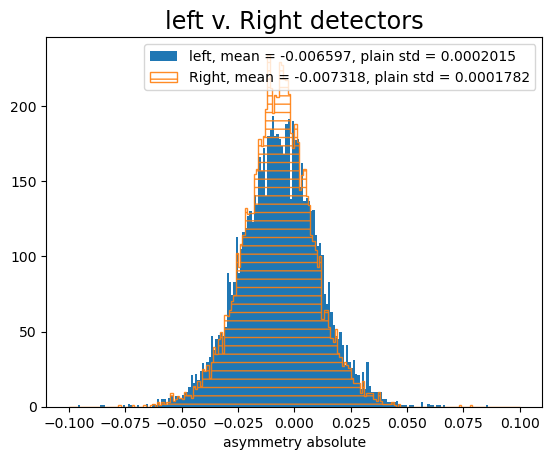

In [146]:
##left v right
## facing downstream towards beam-dump

%matplotlib inline
r = [-0.1,0.1]
b = 200

print(len(all_amp_norm))
# left = [0,3,6,9] ## downstream (?)
left = [3,4,5,6,12,23,22,21]
left_amp_norm = np.asarray(all_amp_norm[left]).flatten()
print(all_amp_norm[left].shape, (left_amp_norm.shape))
mean = np.round(np.mean(left_amp_norm),6)
std = np.round(np.std(left_amp_norm)/(np.sqrt(numruns_tot_D*8)),7) ## len of left_amp_norm = numruns*8 (8 left)
# std = np.round(np.std(left_amp_norm)/(np.sqrt(len(left_amp_norm))),6) ## len of left_amp_norm = numruns*8 (8 left)

plt.hist(left_amp_norm,bins=b,range=r, label = rf'left, mean = {mean}, plain std = {std}')

# right = [1,2,4,5,7,8,10,11] ## downstream (?)
right = [0,11,10,9,15,16,17,18]
right_amp_norm = np.asarray(all_amp_norm[right]).flatten()
print(all_amp_norm[right].shape, (right_amp_norm.shape))
# right_amp_norm = right_amp_norm[0].flatten()
print(len(right_amp_norm))
mean2 = np.round(np.mean(right_amp_norm),6)
std2 = np.round(np.std(right_amp_norm)/(np.sqrt(numruns_tot_D*8)),7) 
# std2 = np.round(np.std(right_amp_norm)/(np.sqrt(len(right_amp_norm))),6) 

plt.hist(right_amp_norm,bins=b,range=r, label = rf'Right, mean = {mean2}, plain std = {std2}', alpha =0.9, hatch='--',histtype='step')

plt.title(rf'left v. Right detectors', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

24
(8, 954) (7632,)
(8, 954) (7632,)
7632


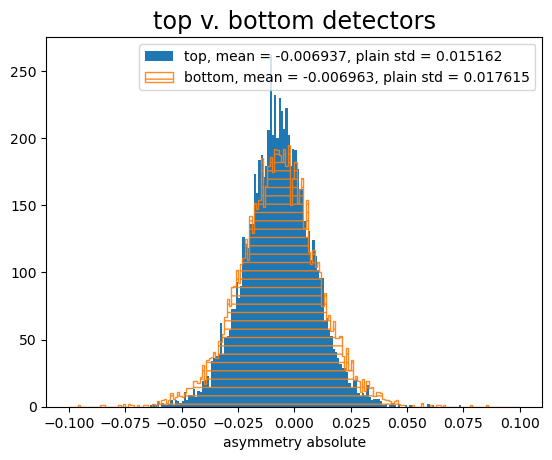

In [140]:
##top v bottom

%matplotlib inline
r = [-0.1,0.1]
b = 200

print(len(all_amp_norm))
# top = [0,3,6,9] ## downstream (?)
top = [0,1,2,3,12,13,14,15]
top_amp_norm = np.asarray(all_amp_norm[top]).flatten()
print(all_amp_norm[top].shape, (top_amp_norm.shape))
mean = np.round(np.mean(top_amp_norm),6)
std = np.round(np.std(top_amp_norm),6) ## len of top_amp_norm = numruns*8 (8 top)
# std = np.round(np.std(top_amp_norm)/(np.sqrt(len(top_amp_norm))),6) ## len of top_amp_norm = numruns*8 (8 top)

plt.hist(top_amp_norm,bins=b,range=r, label = rf'top, mean = {mean}, plain std = {std}')

# bottom = [1,2,4,5,7,8,10,11] ## downstream (?)
bottom = [6,7,8,9,18,19,20,21]
bottom_amp_norm = np.asarray(all_amp_norm[bottom]).flatten()
print(all_amp_norm[bottom].shape, (bottom_amp_norm.shape))
# bottom_amp_norm = bottom_amp_norm[0].flatten()
print(len(bottom_amp_norm))
mean2 = np.round(np.mean(bottom_amp_norm),6)
std2 = np.round(np.std(bottom_amp_norm),6) 
# std2 = np.round(np.std(bottom_amp_norm)/(np.sqrt(len(bottom_amp_norm))),6) 

plt.hist(bottom_amp_norm,bins=b,range=r, label = rf'bottom, mean = {mean2}, plain std = {std2}', alpha =0.9, hatch='--',histtype='step')

plt.title(rf'top v. bottom detectors', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

# ended here

### paper plotting

# only run once!

24 24
8992
8992


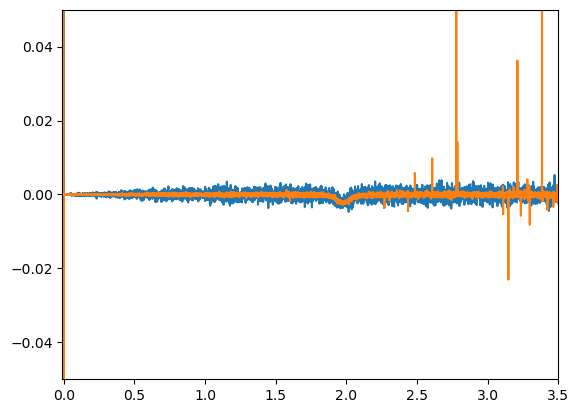

(24, 954, 8992)
deleted a run 109. New shape:  (24, 953, 8992)
New added D/U pulses shape:  (13, 953, 8992) (13, 953, 8992)
24 24
8992
8992


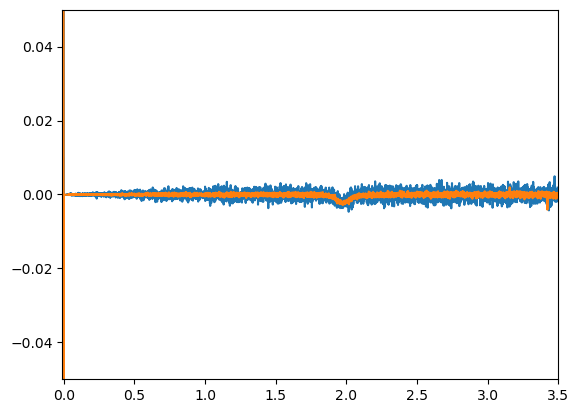

In [32]:
## Testing deleting a specific troublesome run

sum_ch_raw = []
sum_ch_amp = []
for ch in range(0, len(all_raw)):
    chraw = np.sum(all_raw[ch,:], axis = 0)
    champ = np.sum(all_amp[ch,:], axis = 0)
    sum_ch_raw.append(chraw)
    sum_ch_amp.append(champ)

    
sum_ch_amp = sum_ch_amp/np.sum(all_sequences) ## normalize sum of amplitudes!
    
print(len(sum_ch_raw), len(sum_ch_amp))
print(len(sum_ch_raw[0]))

allNaI_raw = np.sum(sum_ch_raw[:], axis = 0)
print(len(allNaI_raw))

plt.figure()
%matplotlib inline
plt.plot(xs, sum_ch_raw[1]/np.sum(all_sequences))
plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.05, 0.05)
plt.xlim(-0.01, 3.5)
plt.show()
# print(len(all_raw_D[0]))
# print(sum_ch_amp)

#############################################################################
if folders_start == 'runs11727-12033':
    tb = 109
    print(all_raw.shape)
    all_raw = np.delete(all_raw, tb,1)
    all_D = np.delete(all_D, tb,1)
    all_U = np.delete(all_U, tb,1)
    print(f'deleted a run {tb}. New shape: ', all_raw.shape)
    print(f'New added D/U pulses shape: ', all_D.shape, all_U.shape)
else:
    print('No runs deleted. Shape: ', all_raw.shape)
    print(f'D/U pulses shape: ', all_D.shape, all_U.shape)
    
#############################################################################
sum_ch_raw = []
sum_ch_amp = []
for ch in range(0, len(all_raw)):
    chraw = np.sum(all_raw[ch,:], axis = 0)
    champ = np.sum(all_amp[ch,:], axis = 0)
    sum_ch_raw.append(chraw)
    sum_ch_amp.append(champ)

    
sum_ch_amp = sum_ch_amp/np.sum(all_sequences) ## normalize sum of amplitudes!
    
print(len(sum_ch_raw), len(sum_ch_amp))
print(len(sum_ch_raw[0]))

allNaI_raw = np.sum(sum_ch_raw[:], axis = 0)
print(len(allNaI_raw))

plt.figure()
plt.plot(xs, sum_ch_raw[1]/np.sum(all_sequences))
plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.05, 0.05)
plt.xlim(-0.01, 3.5)
plt.show()
# print(len(all_raw_D[0]))


### plotting for paper

In [33]:
from functools import reduce
def factors(n):
    return set(reduce(list.__add__,([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

# rebinf = rebinfactors[6]
# print(f'using factor {rebinf}')
# y2_rebin, x_rebin = rebin(y2, x, rebinf)


In [37]:
pulseadd_D = np.sum(all_D[:], axis = 1)

# Sample data
# r = 550
r1 = 2001
r2 = 8501

ch = 1
x = xs[r1:r2]
y1 = pulseadd_D[ch][r1:r2]
# y2 = allNaI_raw[r1:r2]/np.sum(all_sequences)/24*-1 ## flip the sign for plotting
y2 = sum_ch_raw[ch][r1:r2]/np.sum(all_sequences)*-1 ## flip the sign for plotting

rebinfactors = np.sort(np.array(list(factors(len(y2)))))
print(f'possible factors are ', rebinfactors)

rebinf = rebinfactors[5]
print(f'using factor {rebinf}')

y2_rebin, x_rebin = rebin(y2, x, rebinf)

possible factors are  [   1    2    4    5   10   13   20   25   26   50   52   65  100  125
  130  250  260  325  500  650 1300 1625 3250 6500]
using factor 13


In [38]:
%matplotlib qt
# Create the main plot
fig, ax1 = plt.subplots()
lw = 1.2
plt.rcParams["font.family"] = "sans-serif"

# Plot the first dataset
ax1.plot(x, y1, color='blue', label=f'La spectra {channels_all[ch]}', linewidth = lw)
ax1.set_ylabel(r'Counts [arb.]', fontsize='large', color = 'blue')
ax1.set_xlabel('ToF [ms]', fontsize='large')
ax1.tick_params(axis='x', labelsize = 'large')
ax1.tick_params(axis='y', labelsize = 'large', labelcolor = 'blue')
# plt.ylim(0,20)

# Create a twin axes sharing the x-axis
ax2 = ax1.twinx()

# Plot the second dataset

# ax2.plot(x, ydata, color ='blue',alpha = 0.6)
ax2.plot(x_rebin, y2_rebin, ls = '-', color='red', alpha = 1.0, label='asymmetry', linewidth = lw)
# ax2.set_xlabel('Energy [eV]',fontsize = 'large')
ax2.set_ylabel('Asymmetry [absolute]', fontsize='large', color='red')
ax2.tick_params(axis='y', labelsize = 'large', labelcolor = 'red')


# Set y-axis limits
ax1.set_ylim(-0.01e9, 0.5e9)
ax2.set_ylim(-0.004, 0.006)

# Add legends
# fig.legend(loc="upper right", bbox_to_anchor=(0.1, 0.95))


# Display the plot

plt.title(r'La Spectra and Asymmetry', fontsize = 'xx-large')

# plt.xticks(np.arange(-1.0,4.0, 0.5),fontsize = 'large')
ax1.grid(True, which='both',axis = 'both', alpha = 0.75, ls = ':')
ax1.minorticks_on()
# plt.xticks(fontsize = 'xx-large')
# plt.yticks(fontsize = 'x-small')
fig.legend(loc="upper right", bbox_to_anchor=(0.86, 0.88))

# plt.ylabel('NMR Signal Amplitude [mV]',fontsize = 'x-large')
# plt.xlabel('Energy [eV]',fontsize = 'x-large')

# plt.legend(fontsize = 'medium')
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
lw = 1.2

# Plot the first dataset
ax1.plot(x, y1, color='blue', label=f'La spectra {channels_all[ch]}', linewidth = lw)
ax1.set_ylabel(r'Counts [arb.]', fontsize='large', color = 'blue')
ax1.set_xlabel('ToF [ms]', fontsize='large')
ax1.tick_params(axis='x', labelsize = 'large')
ax1.tick_params(axis='y', labelsize = 'large', labelcolor = 'blue')

# Create a twin axes sharing the x-axis
ax2 = ax1.twinx()

# Plot the second dataset

# ax2.plot(x, ydata, color ='blue',alpha = 0.6)
ax2.plot(x_rebin, y2_rebin, ls = '-', color='red', alpha = 1.0, label='asymmetry', linewidth = lw)
# ax2.set_xlabel('Energy [eV]',fontsize = 'large')
ax2.set_ylabel('Asymmetry [absolute]', fontsize='large', color='red')
ax2.tick_params(axis='y', labelsize = 'large', labelcolor = 'red')


# Set y-axis limits
ax1.set_ylim(-0.01e9, 0.5e9)
ax2.set_ylim(-0.004, 0.006)

plt.title(r'La spectrum and asymmetry new temp ', fontsize = 'xx-large')

ax1.grid(True, which='both',axis = 'both', alpha = 0.75, ls = ':')
ax1.minorticks_on()
# plt.xticks(fontsize = 'xx-large')
# plt.yticks(fontsize = 'x-small')
fig.legend(loc="upper right", bbox_to_anchor=(0.90, 0.88))

# plt.legend(fontsize = 'medium')
plt.show()

### end paper plotting

In [192]:
ch = 10
print(len(np.sum(all_raw_D[:,ch], axis = 0)))
testsum = np.sum(all_raw_D[:,ch], axis = 0)
print(testsum)
%matplotlib qt
print(xs)
plt.plot(xs, testsum)
plt.ylim(-100, 100)
plt.xlim(-0.01, 3)
print(len(all_raw_D[0]))

testrans = np.asarray(all_raw_D.transpose(1,0,2))
testranssum = np.sum(testrans[ch,:], axis = 0)
plt.plot(xs, testranssum)
print(testranssum)

8992
[3.77280648e+03 8.52370423e+01 3.22309869e+04 ... 8.21254420e+00
 7.29478682e+00 7.68468218e+00]
[-1.021952 -1.02144  -1.020928 ...  3.580416  3.580928  3.58144 ]
12
[3.77280648e+03 8.52370423e+01 3.22309869e+04 ... 8.21254420e+00
 7.29478682e+00 7.68468218e+00]


In [185]:
print(all_raw_D.shape)
print(all_raw_D[14][5][20:30])
print(all_raw_D[31][6][20:30])

testrans = np.asarray(all_raw_D.transpose(1,0,2))
print(testrans.shape)
print(testrans[5][14][20:30])
print(testrans[6][31][20:30])

(636, 12, 8992)
[ 42.10536834   0.49624384  10.69471701 -21.74036183  32.21412419
 -15.25067682  15.21694059  11.04733538 -60.47922312  -0.58353548]
[  5.43475669  19.3607907   18.19386519  36.15928555  13.78356287
  13.87217111  34.28298049  18.01152043 -56.81306022  20.88652147]
(12, 636, 8992)
[ 42.10536834   0.49624384  10.69471701 -21.74036183  32.21412419
 -15.25067682  15.21694059  11.04733538 -60.47922312  -0.58353548]
[  5.43475669  19.3607907   18.19386519  36.15928555  13.78356287
  13.87217111  34.28298049  18.01152043 -56.81306022  20.88652147]


In [173]:
asyms_raw_summed = []
for ch in range(0, len(all_raw_D[0])):
    chsum = np.sum(all_raw_D[:,ch], axis = 0) 
    asyms_raw_summed.append(chsum)
    
print(len(asyms_raw_summed))
plt.plot(xs, asyms_raw_summed[2])

12


In [175]:
asyms_raw_allNaI = np.sum(asyms_raw_summed[:], axis = 0) 
print(len(asyms_raw_allNaI))
plt.plot(asyms_raw_allNaI)

8992


In [24]:
## need to make this into function and faster

run_asyms_D = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)
run_asyms_U = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)
run_asyms_U_noLi = np.zeros((numruns,len(arr_sizer)-1,len(arr_sizer[0])), dtype=float) ## take out 6Li in upstream (can this be done above?)
run_asyms_All = np.zeros((numruns,25,len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)


for i in range(numruns):
    run_asyms_D[i] = np.load(root+processedfolder+folders_start+asymDendname+runslist_D[i])
    run_asyms_U[i] = np.load(root+processedfolder+folders_start+asymUendname+runslist_U[i])
    run_asyms_U_noLi[i] = run_asyms_U[i,:-1].copy()
    run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))
    
print(len(run_asyms_U_noLi))
print(len(run_asyms_U_noLi[0]))
print(len(run_asyms_U_noLi[0][0]))
print(len(run_asyms_D))
print(len(run_asyms_D[0]))
print(len(run_asyms_D[0][0]))

print(len(run_asyms_All))
print(len(run_asyms_All[0]))
print(len(run_asyms_All[0][0]))

ch_asyms_All = run_asyms_All.transpose(1, 0, 2) ## switches first array to channels and second array to pulses

print(len(ch_asyms_All))
print(len(ch_asyms_All[0]))
print(len(ch_asyms_All[0][0]))

print((ch_asyms_All[0][0][0:5]))
print((run_asyms_U_noLi[0][0][0:5]))
print((run_asyms_D[0][0][0:5]))
print()
print((ch_asyms_All[-1][0][0:5]))
print((run_asyms_D[0][-1][0:5]))
print()
print((ch_asyms_All[12][0][0:5]))
print((run_asyms_D[0][0][0:5]))
print((ch_asyms_All[11][0][0:5]))
print((run_asyms_U_noLi[0][-1][0:5]))
print()
print((ch_asyms_All[-1][0][0:5]))
print((ch_asyms_All[-1][-1][0:5]))

# print((run_asyms_U_noLi[0][0][0:5]))
# print((run_asyms_D[0][0][0:5]))

# print((run_asyms_All[0][0][0:5]))
# print((run_asyms_All[0][-1][0:5]))
# print((run_asyms_D[0][-1][0:5]))


NameError: name 'numruns' is not defined

In [10]:
# print((new_run_asyms_All[0][1][0:5]))
# print((new_run_asyms_All[0][0][0:5]))

# print((new_run_asyms_All[2][-1][0:5]))
# print((new_run_asyms_All[2][-2][0:5]))

In [11]:
print(len(run_asyms_D))
print(len(run_asyms_D[0]))
print(len(run_asyms_D[0][0]))

330
13
9000


In [12]:

xs_cut = np.load(root+processedfolder+'xs_cut.npy')
xs_uncut = np.load(root+processedfolder+'xs_uncut.npy')
xs_cut = xs_cut/1000000
xs_uncut = xs_uncut/1000000  ## convert to ms...

print(len(xs_cut))
print(len(xs_cut[0]))

print(len(xs_uncut))
print(len(xs_uncut[0]))

13
8992
13
9000


In [13]:
All_Li6_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
for r in range(len(ch_asyms_All[0])):
    All_Li6_asyms = All_Li6_asyms + ch_asyms_All[-1][r]
All_Li6_asyms = All_Li6_asyms/numruns
    
NaI_asyms = np.zeros((len(ch_asyms_All)-1, len(arr_sizer[0])), dtype=float) ## num points
for i in range(24): ## 0-11, (24 is 6Li)
    for r in range(len(ch_asyms_All[0])):
        NaI_asyms[i] = NaI_asyms[i] + ch_asyms_All[i][r]
NaI_asyms = NaI_asyms/numruns
        
All_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
for i in range(24): ## 0-23, not 0-24 (24 is 6Li)
    for r in range(len(ch_asyms_All[0])):
        All_NaI_asyms = All_NaI_asyms + ch_asyms_All[i][r]
All_NaI_asyms = All_NaI_asyms/numruns

upstrm = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
for i in range(12): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_All[0])):
        upstrm = upstrm + ch_asyms_All[i][r]
upstrm = upstrm/numruns
print()
dnstrm = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
for i in range(12,24): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_All[0])):
        dnstrm = dnstrm + ch_asyms_All[i][r]
dnstrm = dnstrm/numruns
# Upstrm_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
# for i in range(12): ## 0-11, (24 is 6Li)
#     for r in range(len(ch_asyms_All[0])):
#         Upstrm_NaI_asyms = Upstrm_NaI_asyms + ch_asyms_All[i][r]

# Dnstrm_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points

# for i in range(12,24): ## 12-23, not 12-24 (24 is 6Li)
# #     print( i )
#     Dnstrm_NaI_asyms = Dnstrm_NaI_asyms + ch_asyms_All[i]

print(len(All_NaI_asyms))
print(len(All_Li6_asyms))
print()

print(len(NaI_asyms))
print(len(NaI_asyms[0]))
# print(len(Upstrm_NaI_asyms))
# print(len(Dnstrm_NaI_asyms))


0
1
2
3
4
5
6
7
8
9
10
11

12
13
14
15
16
17
18
19
20
21
22
23
9000
9000

24
9000


In [14]:
print(numruns)

330


In [15]:
print(len(run_asyms_U_noLi))
print(run_asyms_U_noLi[20,11,2000:2010])
print(run_asyms_U_noLi[20][11][2000:2010])

print(len(run_asyms_U_noLi[0:330,11,2000:2010]))
print(len(run_asyms_U_noLi[0:330][11][2000:2010]))

# print((run_asyms_U_noLi[0][5][4000:4010]*330))
print(np.average(run_asyms_U_noLi[0:380,11,7900]*330))
print(NaI_asyms[11][7900])

330
[-0.00019739 -0.00019493 -0.00019349 -0.00019422 -0.00019638 -0.00019512
 -0.00019456 -0.00019479 -0.00019415 -0.00019385]
[-0.00019739 -0.00019493 -0.00019349 -0.00019422 -0.00019638 -0.00019512
 -0.00019456 -0.00019479 -0.00019415 -0.00019385]
330
0
0.13468340116256292
0.0004081315186744347


In [16]:
m = 8
# a = All_Li6_asyms
a = All_NaI_asyms
b = a.reshape(-1, m).mean(axis=1)
c = xs_cut[0]
d = c.reshape(-1, m).mean(axis=1)
print(len(a))
print(len(b))
print(len(d))

def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

rebinf = 8
All_NaI_asyms_rebin8, xs_cut_rebin8 = rebin(All_NaI_asyms, xs_cut[0], rebinf)
All_Li6_asyms_rebin8, xs_cut_rebin8 = rebin(All_Li6_asyms, xs_cut[0], rebinf)

print(len(All_NaI_asyms_rebin8))
print(len(xs_cut_rebin8))

9000
1125
1124
1125
1124


In [17]:
print(numruns)

330


In [21]:
# legend = []
%matplotlib qt

# plt.plot(xs_uncut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], All_NaI_asyms/(24), label='All NaI')
# plt.plot(xs_cut[0], (All_NaI_asyms/(24)), label='All NaI, no rebinning: ')
# plt.plot(xs_uncut[0], (All_NaI_asyms/(24)), label='All NaI, no rebinning. No t0 alignment')
# plt.plot(xs_cut[0], (upstrm/(12)), label='upstrm, no rebinning: ')
# plt.plot(xs_cut[0], (dnstrm/(12)), label='dnstrm, no rebinning: ')

# plt.plot(xs_cut[0], (All_Li6_asyms), label='Li6, no rebinning: ')
# plt.plot(xs_cut_rebin8, (All_NaI_asyms_rebin8/(24)), label='All NaI, rebinning: ' + str(rebinf))
# plt.plot(xs_cut_rebin8, (All_Li6_asyms_rebin8), label='Li6, rebinning: ' + str(rebinf))

# plt.plot(xs_uncut[0], NaI_asyms[7] , label='NaI D1')
plt.plot(d, b[:-1]/24, label='All NaI')

# plt.plot(xs_uncut[0], All_Li6_asyms , label='6Li')
# plt.plot(xs_cut, All_Li6_asyms/4275 , label='6Li')
# plt.plot(d, b, label='6Li')

    
plt.title(f'asym, {numruns} runs, (' + str(numruns*4/60) + ' hours)') 
plt.xlabel("time from trigger (ms)")
plt.ylabel('absolute')

plt.ylim(-0.5,0.5)
# plt.xlim(xs_cut[1800],xs_cut[-1])
# plt.xlim(xs_uncut[0][1800],xs_uncut[0][-1])

# plt.axvline(xs[0][baseL], ls = '--')
# plt.axvline(xs[0][baseR], ls = '--')
# plt.axvline(xs_cut[1][7800], ls = '--', c ='g')
plt.axvline(xs_cut[1][7500], ls = '--', c ='r')
plt.axvline(xs_cut[1][7200], ls = '--', c ='r')

#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

plt.legend()
plt.show()

In [ ]:
print(root+processedfolder+folders_start+'/asym_D/'+runslist_D[1])

In [ ]:
xs_uncut = np.load(root+processedfolder+'xs_uncut.npy')
print(len(xs_uncut[0]))

In [16]:
testload0 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[0])
testload1 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[1])
testload2 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[2])
testload3 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[3])
testload4 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[4])
testload5 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[5])
testload6 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[6])
testload7 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[7])
testload8 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[8])
testload9 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[9])
testload10 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[10])
testload11 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[11])
testload12 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[12])
testload13 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[13])
testload14 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[14])
testload15 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[15])
testloads = [testload1, testload2, testload3, testload4, testload5, testload6, testload7, testload8, testload9, testload10, testload11, testload12, testload13, testload14, testload15, testload0]

print(len(testload0))
print(len(testload0[0]))


13
8992


In [17]:
print(type(testload12))
print(len(testload12))
print(len(testload12[1]))
print(testload12[1][2100:2110])

print(type(testload1))
print(len(testload1))
print(len(testload1[1]))
print(testload1[1][2100:2110])

<class 'numpy.ndarray'>
13
8992
[ 0.00545513 -0.00232839  0.00913183  0.00257728 -0.00176993  0.00101849
  0.00163765  0.00434007  0.00353119  0.00101663]
<class 'numpy.ndarray'>
13
8992
[ 0.00149679 -0.00161068 -0.00074242 -0.0005354  -0.00117681 -0.00113059
  0.0050438  -0.00223947 -0.00453362 -0.00859197]


In [18]:
testa = np.array([1,4,10])
testb = np.array([6,2,-1])
tests = [testa, testb]

print(np.sum(tests, axis =0))
print(testa+testb)

[7 6 9]
[7 6 9]


In [19]:
alltests = np.zeros((len(testload1),len(testload1[0])), dtype=np.float64)
for i in range(len(testloads)):
    for ch in range(len(testloads[0])):
        alltests = np.add(alltests,testloads[i][ch])



In [20]:
# alltests = np.sum(testloads, axis =0)
print(len(alltests))
print(len(alltests[0]))
print(alltests[-1][2100:2110])
print(testloads[-1][2][2100:2110])

13
8992
[ 0.06580914 -0.00674936  0.01945315 -0.04193713  0.00197393  0.0245911
  0.07918334  0.07143564  0.00753719  0.00066482]
[ 0.00239088  0.00161905 -0.00045938 -0.00167427  0.00082221  0.00120667
 -0.00058788 -0.00259709  0.00513048  0.00540297]


In [23]:
# legend = []
%matplotlib qt

# plt.plot(xs_uncut[0], alltests[0] , label='alltests')
# plt.plot(xs_uncut[0], testload1[1] , label='testload1')
# plt.plot(xs_cut[0], NaI_asyms[0] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[5] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[19] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[21] , label='NaI D1')

# plt.plot(xs_cut, ch_asyms[2] , label='NaI D1')
# plt.plot(xs_cut, All_NaI_asyms/24, label='All NaI')
# plt.plot(d, b/24, label='All NaI')

# plt.plot(xs_cut, All_Li6_asyms , label='6Li')
# plt.plot(xs_cut, All_Li6_asyms/4275 , label='6Li')
# plt.plot(d, b, label='6Li')

    
plt.title('asym') 
plt.xlabel("time from trigger (ns)")
plt.ylabel("ADC")

plt.ylim(-3,3)
# plt.xlim(xs_cut[1800],xs_cut[-1])
plt.xlim(xs_uncut[0][1800],xs_uncut[0][-1])

# plt.axvline(xs[0][baseL], ls = '--')
# plt.axvline(xs[0][baseR], ls = '--')
#plt.axvline(xs[1][intgrL], ls = '--', c ='g')
#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

plt.legend()
plt.show()

In [18]:
a = np.array([[2,6,8,9,30], [2,6,8,9,30]*4])
b = np.array([[1,3,2,3,10], [2,6,8,9,30]*2])
c = np.divide(a,b)
print(c)

C:\Users\gabeo\AppData\Local\Temp\ipykernel_85532\1335267064.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array([[2,6,8,9,30], [2,6,8,9,30]*4])
C:\Users\gabeo\AppData\Local\Temp\ipykernel_85532\1335267064.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b = np.array([[1,3,2,3,10], [2,6,8,9,30]*2])


TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [24]:
import os
import numpy as np
os.chdir('F:/LANL/processed_data/')

searchfolder = 'F:/LANL/processed_data/'
search_arr = sorted(os.listdir(os.getcwd()))
print(search_arr)
print(search_arr[0])
folder_start = 'runs'+'12034-12363'
folder_end = 'runs'+'12364-12684'
# folder_end = 'testother2'
print(folder_start)
start_i = search_arr.index(folder_start)
end_i = search_arr.index(folder_end)
print(start_i)
print(end_i)

firstfile = sorted(os.listdir(searchfolder+folder_start+'/asym_D'))[0]
arr_sizer = np.load(searchfolder+folder_start+'/asym_D/'+firstfile)
print(arr_sizer)
print(len(search_arr[start_i:end_i+1]))
print(len(arr_sizer))
print(len(arr_sizer[0]))
# print(len(arr_size[0][0]))
numruns = len(sorted(os.listdir(searchfolder+folder_start+'/asym_D')))
# print(numruns)
# run_asyms = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
# print(len(run_asyms))
# print(len(run_asyms[0]))
# print(len(run_asyms[0][0]))

folder_arr = []

# dir = folder_start + folder_start
for dir in search_arr[start_i:end_i+1]:
    run_asyms = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
    # folder_arr.append(run_asyms)
    print(dir)
    for file in ((sorted(os.listdir(searchfolder+dir+'/asym_D')))):
        # print(file)
        if file[-5] == 'U': ## Up and Down stream. Case sensitive!
            print(file)
        elif file[-5] == 'D':
            ## add to downstream sums
            print(file)
            # print(os.listdir(searchfolder+dir+'/asym')[file]+'hihihi')
        # if file.endswith == 'D.npy':
        #     print(os.listdir(searchfolder+dir+'/asym')[file]+'hihihi')
    #     run_asyms[file] = np.load(searchfolder+dir+'/asym/'+file)
    # folder_arr.append(run_asyms)

['La_sample', '_temp_xs.npy', 'runs11139-11412', 'runs11413-11726', 'runs11727-12033', 'runs12034-12363', 'runs12364-12684', 'runs13564-13604', 'runs13605-13735', 'runs13736-13851', 'runs88888-99999', 'testother', 'testother2', 'xs_cut.npy', 'xs_uncut.npy']
La_sample
runs12034-12363
5
6
[[-3.69633597e-01 -2.63165523e+00 -3.56222096e-01 ...  7.36716205e-02
  -2.55044314e-02 -1.71281466e-02]
 [ 6.17067505e-03 -1.30841489e+00  6.78591744e-01 ... -1.34713175e-04
  -5.34848008e-02 -7.30152590e-02]
 [ 2.31972124e-02 -1.91469631e+00  5.00007395e-02 ... -2.82448048e-02
  -3.13920185e-02 -3.43898985e-02]
 ...
 [ 8.50719814e-01  1.38581159e+00 -2.28252735e+00 ... -1.04070546e-02
  -7.99308281e-02  2.57297331e-02]
 [-8.17663618e-03 -1.30692453e+00  3.52806129e+00 ...  2.36817996e-02
  -3.65283320e-02 -3.03282009e-02]
 [ 4.34295148e-03  6.05849456e-02 -5.80115256e-02 ... -4.32947513e-03
  -8.30378287e-03  1.41922170e-04]]
2
13
8992
runs12034-12363
12034_asym_D.npy
12035_asym_D.npy
12036_asym_D.npy

In [3]:

# In[13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import pandas as pd
import statistics as st
import os
from numba import njit
import time
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from loguru import logger

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# for arg in sys.argv:
#     run_num=str(arg).zfill(5)
#     # print(run_num)

# chan_enab = int(sys.argv[-1])
# run_start=str(sys.argv[1]).zfill(5)
# run_end=str(sys.argv[2]).zfill(5)
# run_num=str(sys.argv[3]).zfill(5)
run_num = "11164" 

# print(os.getcwd())
os.chdir('F:/LANL/')
datadir = 'D:\LANSCE_FP12_2023\data/'
folder = 'runs11139-11412/'
SFNormFile = 'SF_Norm_files/'+folder+run_num
# datadir = 'D:/LANSCE_FP12_2023/data/' ## add directory of hard drive
# uniquefolder = "runs" + str(run_start) + "-" + str(run_end) +"/"
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num

statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'
# processedpulsefolder = '/processed_data/'+uniquefolder+'pulses_added/'
# processedasymfolder = '/processed_data/'+uniquefolder+'asym/'
# AddedPulseSavename = processedpulsefolder+run_num+'_pulsesadded_d'
# AsymSavename = processedasymfolder+run_num+'_asym_d'
# logger.add("F:/LANL/processed_data/" + uniquefolder + '0_ErrorLog_'+run_start+'_'+run_end+'.txt', delay = False)

# print('processing data: ' + uniquefolder + '/run' + run_num)

# AddedPulseSavename = processedpulsefolder+uniquefolder+run_num+'_pulsesadded_d'
# AsymSavename = processedasymfolder+uniquefolder+run_num+'_asym_d'
# print(os.getcwd()+processedpulsefolder)
# if not os.path.exists(os.getcwd()+processedpulsefolder) or not os.path.exists(os.getcwd()+processedasymfolder):
#     # Create the directory
#     os.makedirs(os.getcwd()+processedpulsefolder)
#     os.makedirs(os.getcwd()+processedasymfolder)
#     print("Directory created successfully")
# else:
#     pass

# print(os.getcwd() + folder)

# get_ipython().run_line_magic('matplotlib', 'qt')

start = time.time()
fullstart = time.time()

## cannot handle all 24 detectors at once, memory issue... can look into np.empty and deleting variables if needed
#chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]) ## all
chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,24]) ## downstream
#chan_enab = np.array([12,13,14,15,16,17,18,19,20,21,22,23,24]) ## upstream

#@jit(nopython = True)
# read_data = np.array([])
# fileLength = np.array([])
read_data = []
fileLength = []


def open_file():
    for el in chan_enab:
        f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
        # f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
        read_data.append(np.fromfile(file=f, dtype=np.uint16))
        f.close()
        fileLength.append(len(read_data[-1]))
    return read_data, fileLength

open_file()

fileLength = np.asarray(fileLength)
read_data = np.asarray(read_data) ## in detector's case, all are the same size samples, so can do read_data as np array

if chan_enab[-1] != 24:
    emessage = ('last channel is not 6Li detector')
    # logger.error(run_num + emessage)
    raise Exception(emessage)

end = time.time()
# print('file open time: ' + str(end-start))            

# print('saving processed data to ' + AsymSavename)
print("Channel is " + str(chan_enab))
end = time.time()
print(end-start)
# print(read_data)


# Store the big header for each channel in arrays


Channel is [ 0  1  2  3  4  5  6  7  8  9 10 11 24]
12.803877115249634


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# os.chdir('F:/LANL/processed_data/')
# processedfolder = 'F:/LANL/processed_data/'

os.chdir('C:/Users/gabeo/Desktop/analysis_temp/')
# os.chdir('/mnt/c/Users/gabeo/Desktop/analysis_temp/')
root = os.getcwd()

processedfolder = '/processed_data/'
   
search_arr = sorted(os.listdir(root + processedfolder))
print(search_arr)
print(search_arr[0])
folders_start = 'runs'+'12364-12684'
# folders_end = 'runs'+'88888-99999'
folders_end = 'testing'
print(folders_start)
start_i = search_arr.index(folders_start)
end_i = search_arr.index(folders_end)
print(start_i)
print(end_i)
print(len(search_arr[start_i:end_i+1]))
firstfile = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D/'))[0]
arr_sizer = np.load(root+processedfolder+folders_start+'/asym_D/'+firstfile)
# print(arr_sizer)
print(len(arr_sizer))
print(len(arr_sizer[0]))
print(len(search_arr[start_i:end_i+1]))
   
runslist_D = np.zeros((len(search_arr[start_i:end_i+1]), numruns,len(arr_sizer),len(arr_sizer[0])), dtype=[int, in
t, int, str]) ## num pulses, num channels, num points (one dataset per pulse per channel)
runslist_F = runslist_D
   
for f in range(start_i, end_i):
    print(f)
    print(search_arr[f])
    runslist_D[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D'))
    runslist_U[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_U'))

numruns = len(runslist_U)
print(numruns)
# run_asyms_D = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
# print(len(run_asyms_D))
# print(len(run_asyms_D[0]))
# print(len(run_asyms_D[0][0]))

In [2]:
# In[14]:

BoardID = []
recordLength = []
numSamples = []
eventCounter = []
decFactor = []
chanDec = []
postTrig = []
groupStart = []
groupEnd = []
timestamp= []
sizeFirstEvent = []
TTT = []


Target is La


In [3]:
# In[15]:

preTime = []
startTime = []
endTime = []
resolution = []
xs = [] 

for i in range(0,len(chan_enab)):
    preTime.append((100-postTrig[i])*recordLength[i]/100)
    startTime.append((-1*preTime[i]*16*decFactor[i] + groupStart[i]*16*decFactor[i]))
    endTime.append((-1*preTime[i]*16*decFactor[i] + groupEnd[i]*16*decFactor[i]))
    resolution.append(16*chanDec[i]*decFactor[i])
#     print("Pretime for channel", chan_enab[i],"is " + str(preTime[i]) + "; start time is " + str(startTime[i]) + "; end time is " + str(endTime[i]) 
#           + "; resolution is " + str(resolution[i]) + "ns")
    xs.append(np.arange(startTime[i],(numSamples[i])*resolution[i]+startTime[i], resolution[i]))

#np.asarray(preTime)
#np.asarray(startTime)
#np.asarray(endTime)
#np.asarray(resolution)
xs = np.asarray(xs) ## can convert xs to np array here because all detectors same numsamples

# In[16]:

start=time.time()

@njit
def dataread(data, channels, fileLen, numSamps):
    numRuns = int((fileLen[0]-20-numSamps[0])/(numSamps[0]+6)+1)
    ys_arr = np.zeros((len(channels), numRuns,numSamps[0]), dtype=np.uint16)
    ETTT_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    eventcount_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    for i in range(0,len(channels)):
        eventCount = 0
        byteCounter = 0
            #byte counter is really 2bytecounter, lol
        while byteCounter < fileLen[i]:
            if byteCounter == 0:
                ETTT_arr[i]=TTT[i]
                #ETTT_arr[i].append(TTT[i])
                eventcount_arr[i]=(eventCounter[i])
                byteCounter = 20
            else:
                ETTT_arr[i]=(data[i][byteCounter]+(data[i][byteCounter+1]<<16)+(data[i][byteCounter+2]<<32))
                eventcount_arr[i]=(data[i][byteCounter+4]+(data[i][byteCounter+5]<<16))
                byteCounter += 6
            for j in range(0, numSamps[i]):
                #if j == 0:
                    #ys_arr[i].append([])
                #print(byteCounter)
                ys_arr[i][eventCount][j]=data[i][byteCounter]
                byteCounter += 1
            eventCount += 1
    return ys_arr, ETTT_arr, eventcount_arr

#start=time.time()
#ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, [25], fileLength, numSamples) ##hardcoded channel 25 for He
ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data, chan_enab, fileLength, numSamples) ##hardcoded channels for coils

end = time.time()
print('dataread from binary time: ' + str(end-start))            


dataread from binary time: 2.5880939960479736


In [4]:
# In[17]:
timeDif=[]
for i in range(0,len(chan_enab)):
    timeDif.append([])
    for j in range(len(ETTT_arr[i])-1):
        timeDif[i].append((ETTT_arr[i][j+1]-ETTT_arr[i][j])*8)
#     print("Min time difference for channel", chan_enab[i], "is", min(timeDif[i]), "ns")
#     print("Max time difference for channel", chan_enab[i], "is", max(timeDif[i]), "ns \n")
#print(timeDif)
# In[18]:

## basesub and plotting ##
baseL = 0
baseR = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)
    
legend =  ['NaI', 'R']

start = time.time()

s = 0 ## pulse to look at
t=s+1

## dont know why this is so slow ##
def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            plt.plot(xs[i], tempys_basesub[i][j]) #label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
            plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition' + transitions[p]) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
            plt.legend()
            
#plotter(ys_arr[9:], xs[9:], baseR, numSamples) ##plot coils

In [5]:
ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)

@njit ## jit is faster for large # channels, slower for small # channels
def basesub(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
    return tempys_basesub

## got rid of sums here, should be done after aligning and cutting
## got rid of xs in basesub, don't think we need them as an input 06.10.24

for i in range(len(ys_basesub)):
    ys_basesub[i] = basesub(ys_arr[i], baseR, numSamples)

ys_basesub[-1] = ys_basesub[-1]*-1 ## invert 6Li to positive signal. Comment out if not using

end = time.time()
print('plotting and/or base subtraction time: ' + str(end-start))            

# ## Load SF Sorting and norm ##

# In[19]:

## Load in SF and He normalization information 
df_SF = pd.read_hdf(SFNormFile + '.h5', key='df_0')
df_HE = pd.read_hdf(SFNormFile + '.h5', key='df_1')

SF_Sort_arr = df_SF[['nicknames', 'transition_locations']].to_numpy().T
He_Norm_arr = df_HE[['pulse', 'norms']].to_numpy().T

print((SF_Sort_arr))
print(len(SF_Sort_arr[1]))

NormFactor = 100000  ## He integrals are huge, this normalizes all of those by a constant value for ease of use
HeNorms= (He_Norm_arr[1])/NormFactor


plotting and/or base subtraction time: 4.809298276901245
[[5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0
  1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4
  5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0
  1 2 3 4]
 [0 45 90 135 180 225 270 315 360 405 450 495 540 585 630 675 720 765 810
  855 900 945 990 1035 1080 1125 1170 1215 1260 1305 1350 1395 1440 1485
  1530 1575 1620 1665 1710 1755 1800 1845 1890 1935 1980 2025 2070 2115
  2160 2205 2250 2295 2340 2385 2430 2475 2520 2565 2610 2655 2700 2745
  2790 2835 2880 2925 2970 3015 3060 3105 3150 3195 3240 3285 3330 3375
  3420 3465 3510 3555 3600 3645 3690 3735 3780 3825 3870 3915 3960 4005
  4050 4095 4140 4185 4230 4275 4320 4365 4410 4455 4500 4545 4590 4635
  4680 4725 4770 4815 4860 4905 4950 4995]]
112


In [11]:
# In[20]:

# for ind in df.index:
#     print('transition: '+ str(df['nicknames'][ind]) + ' location: ' + str(df['transition_locations'][ind]))
#print(df['transition_locations'],df['nicknames'] )

# try:
## this could probably be prettier, but it seems to work...
def organize_SF(SFsort_info): ## sometimes pulse 0 has the state switch. In that case, need to account by if clauses below
    counter = 0
    seq = 0
    seq_arr = ([[],[],[]])
    smallerseq = []
    smallerstateis = []
    for i in range(len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))):  ##111 mod 8 = 7, so essentially 111-7 = 104
        counter = counter+1
        if counter < 8:
            if (SF_Sort_arr[1][i]) == 0:
                smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
                smallerseq.append(SFsort_info[0][i+1])
                seq = seq+1
                continue
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            # print(SF_Sort_arr[0][i+1])
            # print(smallerseq)
        elif counter == 8:
            if ((SF_Sort_arr[1][i])+5) == 5000:
                print(((SF_Sort_arr[1][i])+5))
                seq = seq+1
                seq_arr[0].append(seq)
                seq_arr[1].append(smallerseq)   
                seq_arr[2].append(smallerstateis)
                seq_arr[0] = [x-1 for x in seq_arr[0]] ## reset to sequences are 1-14 instead of 2-15
                break
            seq = seq+1
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            seq_arr[0].append(seq)
            seq_arr[1].append(smallerseq)   
            seq_arr[2].append(smallerstateis)
            smallerseq = []
            smallerstateis = []
            counter  = 0
    return seq_arr

def find_leftover(SFsort_info, seq_arr):
    left = [[seq_arr[0][-1]+1],[],[]]
    counter = 0
    for i in range((len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))), len(SFsort_info[1])-1):
        counter = counter+1
        if counter < 8:
            left[1].append(SFsort_info[0][i+1])
            left[2].append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
    return left

#try:
sequence = organize_SF(SF_Sort_arr)
if len(sequence[0]) == 14:
    leftovers = [[sequence[0][-1]],[sequence[1][-1]],[sequence[2][-1]]]
    for i in range(len(sequence)):
        sequence[i].pop(-1)
else:
    leftovers = find_leftover(SF_Sort_arr, sequence)

# except Exception as e:
#     logger.error(run_num + ' failed during sequencing')
#     logger.exception(e)

print((sequence[0]))
print(len(sequence))
print((sequence[1]))
    
        # sequence[i] = sequence[i].pop(-1)
# leftovers = [[sequence[0][-1]+1],[],[]]

# except Exception as e:
#     logger.error(run_num + ' failed during leftovers sequencing')
#     logger.exception(e)
# leftovers = find_leftover(SF_Sort_arr)

print(leftovers)

print('sequences '+str(sequence[0]))
print('sequence order: '+str(sequence[1][0]))
# print(leftovers)


5000
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
3
[[6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5]]
[[14], [[6, 7, 0, 1, 2, 3, 4]], [[[4685, 4725], [4730, 4770], [4775, 4815], [4820, 4860], [4865, 4905], [4910, 4950], [4955, 4995]]]]
sequences [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
sequence order: [6, 7, 0, 1, 2, 3, 4, 5]


In [13]:
print(sequence[0])
print(sequence[1])
print(len(sequence[0]))
print(len(sequence[1]))
print(len(sequence[2]))
print((sequence[2][0]))
print((sequence[2][-1]))
print((SF_Sort_arr[1][0])+5)
print(SF_Sort_arr[1][0+1])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[[6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5]]
13
13
13
[[5, 45], [50, 90], [95, 135], [140, 180], [185, 225], [230, 270], [275, 315], [320, 360]]
[[4325, 4365], [4370, 4410], [4415, 4455], [4460, 4500], [4505, 4545], [4550, 4590], [4595, 4635], [4640, 4680]]
5
45
